# Week 0: смотрим на лоссы

In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html

!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 7.9 MB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 3.5 MB 5.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.1+cu113.html
     |████████████████████████████████| 2.4 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 467 kB 4.9 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=c2c74e329f78320020f0ebca4b9e307094bda026c5ba93da9c24dec8f73ab016


In [2]:
import torch
import torch.nn as nn
import torch_geometric as tg
import networkx as nx

In [3]:
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='/tmp/REDDIT-BINARY', name='REDDIT-BINARY')
dataset = dataset[:500]

Extracting /tmp/REDDIT-BINARY/REDDIT-BINARY/REDDIT-BINARY.zip
Processing...
Done!


In [4]:
print(len(dataset))
dataset[0]

500


Data(edge_index=[2, 480], y=[1], num_nodes=218)

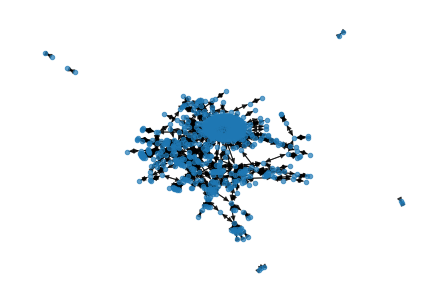

In [5]:
from torch_geometric.utils import to_networkx

nx_sample = to_networkx(dataset[8])
nx.draw(nx_sample, 
        alpha=0.7, 
        node_size=20)

In [6]:
dataset[0]

Data(edge_index=[2, 480], y=[1], num_nodes=218)

In [7]:
dataset[0].edge_index.shape[1]

480

In [38]:
from torch_geometric.data import Data
import numpy as np

def create_train_test_split(sample, p=0.07):
    train_edge_index = sample.edge_index
    edge_mask = np.random.choice([True, False], train_edge_index.shape[1], p=[1-p, p])
    edges_set = set()
    for i in range(train_edge_index.shape[1]):
        if not edge_mask[i]:
            edges_set.add((train_edge_index[0][i].item(), train_edge_index[1][i].item()))
            edges_set.add((train_edge_index[1][i].item(), train_edge_index[0][i].item()))
    for i in range(train_edge_index.shape[1]):
        if (train_edge_index[0][i].item(), train_edge_index[1][i].item()) in edges_set:
            edge_mask[i] = False
    train_edge_index = sample.edge_index[:, edge_mask]
    test_edge_index = sample.edge_index[:, ~edge_mask]
    return Data(edge_index=train_edge_index, num_nodes=sample.num_nodes), Data(edge_index=test_edge_index, num_nodes=sample.num_nodes)

create_train_test_split(dataset[0])

(Data(edge_index=[2, 422], num_nodes=218),
 Data(edge_index=[2, 58], num_nodes=218))

In [39]:
train_data = []
test_data = []
for i in range(len(dataset)):
    cur_train, cur_test = create_train_test_split(dataset[i])
    train_data.append(cur_train)
    test_data.append(cur_test)

In [40]:
def apk(pred, target, k):
    if len(pred) >= k:
        pred = pred[:k]

    ans, cnt = 0, 0
    tot = min(len(target), k) 
    s = set()
    for i in range(len(pred)):
        if pred[i] in target and pred[i] not in s:
            cnt += 1
            ans += cnt / (i + 1)
            s.add(pred[i])
    return ans / tot


def mapk(pred, target, k):
    assert len(pred) == len(target)
    sum_metric = 0
    for cur_pred, cur_target in zip(pred, target):
        sum_metric += apk(cur_pred, cur_target, k)
    return sum_metric / len(pred) 

## 1. Node2Vec

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [43]:
from torch_geometric.nn import Node2Vec
from tqdm.auto import trange


predictions = []
EPOCHS = 40
K = 100

for i in trange(len(train_data)):
    data = train_data[i]
    model = Node2Vec(data.edge_index, embedding_dim=32, walk_length=10,
              context_size=10, walks_per_node=10).to(device)
    loader = model.loader(batch_size=32, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    model.train()
    for j in range(EPOCHS):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw.to(device), neg_rw.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    existing_edges = set()
    for j in range(data.edge_index.shape[1]):
        existing_edges.add((data.edge_index[0][j].item(), data.edge_index[1][j].item()))
        existing_edges.add((data.edge_index[1][j].item(), data.edge_index[0][j].item()))

    results = []
    embeddings = model.embedding.weight.cpu().detach().numpy()
    for p0 in range(embeddings.shape[0]):
        l0 = sum(embeddings[p0] * embeddings[p0])
        for p1 in range(p0 + 1, embeddings.shape[0]):
            if (p0, p1) in existing_edges:
                continue
            l1 = sum(embeddings[p1] * embeddings[p1])
            score = sum(embeddings[p0] * embeddings[p1]) / (l0 * l1)
            results.append((score, p0, p1))
    results = sorted(results)[::-1][:K]
    results = [(cur[1], cur[2]) for cur in results]
    predictions.append(results)
    


  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
test_arr = []
for i in range(len(test_data)):
    cur_edges = []
    for j in range(test_data[i].edge_index.shape[1]):
        v0 = test_data[i].edge_index[0][j].item()
        v1 = test_data[i].edge_index[1][j].item()
        cur_edges.append((min(v0, v1), max(v0, v1)))
    test_arr.append(cur_edges)
mapk(predictions, test_arr, K)

5.0551098452926256e-05

## 2. GNN + BCE

In [45]:
import random
from copy import deepcopy

class GraphCollector:
    def __init__(self, train_graphs):
        self.train_arr = deepcopy(train_graphs)
        self.pos2id = dict()
        self.id2pos = dict()

        cur_v = 0
        self.starts = []
        for i in range(len(self.train_arr)):
            self.starts.append(cur_v)
            for j in range(self.train_arr[i].edge_index.shape[1]):
                self.train_arr[i].edge_index[0][j] += cur_v
                self.train_arr[i].edge_index[1][j] += cur_v

            for j in range(self.train_arr[i].num_nodes):
                self.pos2id[(i, j)] = cur_v
                self.id2pos[cur_v] = (i, j)
                cur_v += 1
            
        self.N = cur_v
        self.all_edges = []
        for i in range(len(self.train_arr)):
            for num_edge in range(self.train_arr[i].edge_index.shape[1]):
                v0 = self.train_arr[i].edge_index[0][num_edge].item()
                v1 = self.train_arr[i].edge_index[1][num_edge].item()
                self.all_edges.append((min(v0, v1), max(v0, v1)))

        self.set_edges = set(self.all_edges)
        self.all_edges = torch.tensor(self.all_edges).permute(1, 0).to(device)
        self.all_vertexes = torch.arange(0, self.N).to(device)

    def generate_samples(self, batch_size, p_positive):
        id_graph = random.randint(0, len(self.train_arr) - 1)
        all_graph = torch.arange(self.starts[id_graph], self.starts[id_graph] + self.train_arr[id_graph].num_nodes) 
        
        part0, part1, labels = [], [], []
        for k in range(batch_size):
            if random.random() < p_positive:
                id_edge = random.randint(0, self.train_arr[id_graph].edge_index.shape[1] - 1)
                v0 = self.train_arr[id_graph].edge_index[0][id_edge].item()
                v1 = self.train_arr[id_graph].edge_index[1][id_edge].item()
                part0.append(v0)
                part1.append(v1)
                labels.append(1)
            else:
                v0, v1 = None, None 
                while True:
                    v0 = random.randint(0, self.train_arr[id_graph].num_nodes - 1)
                    v1 = random.randint(0, self.train_arr[id_graph].num_nodes - 1)
                    if v0 == v1 or (min(v0, v1), max(v0, v1)) in self.set_edges:
                        continue
                    break
                part0.append(v0 + self.starts[id_graph])
                part1.append(v1 + self.starts[id_graph])
                labels.append(0)
        return np.array(part0), np.array(part1), torch.tensor(labels).to(device)


In [46]:
graphs = GraphCollector(train_data)
graphs.generate_samples(24, 0.5)

(array([116589, 117499, 116821, 116569, 116589, 116959, 116543, 116948,
        117467, 116653, 116589, 117275, 116943, 117388, 117393, 116884,
        116766, 117506, 117313, 116804, 116589, 116846, 116589, 116799]),
 array([116816, 116656, 116589, 117245, 117405, 116600, 116589, 116990,
        117368, 116899, 116823, 116704, 117472, 116834, 116731, 117365,
        116578, 116810, 116606, 116589, 116548, 117293, 117481, 117502]),
 tensor([1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
        device='cuda:0'))

In [47]:
class GNN(nn.Module):
    def __init__(self, 
                 num_vertexes, 
                 embedding_size, 
                 hidden_size, 
                 hidden_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_vertexes, embedding_size)
        self.layers = nn.ModuleList([tg.nn.GCNConv(embedding_size, hidden_size)])
        for i in range(hidden_layers):
            self.layers.append(tg.nn.GCNConv(hidden_size, hidden_size))
        self.relu = nn.ReLU()
        self.last = nn.Sequential(
            nn.Linear(2 * hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, vertexes, edges, first_part, second_part):
        hidden = self.embedding(vertexes)
        for i in range(len(self.layers)):
            hidden = self.layers[i](hidden, edges)
            hidden = self.relu(hidden)
        fst = hidden[first_part]
        scd = hidden[second_part]
        concated = torch.cat((fst, scd), dim=1)
        return self.last(concated)

        

In [48]:
model = GNN(graphs.N, 64, 128, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss()

In [49]:
from tqdm.auto import trange

iterations = 10000
batch_size = 64
p_positive = 0.5

pbar = trange(iterations)
for _ in pbar:
    optimizer.zero_grad()
    first_part, second_part, target = graphs.generate_samples(batch_size, p_positive)
    output = model(graphs.all_vertexes, graphs.all_edges, first_part, second_part).squeeze(1)
    loss = criterion(output, target + 0.0)
    loss.backward()
    pbar.set_description(str(loss.item()))
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [50]:
from torch_geometric.nn import Node2Vec
from tqdm.auto import trange


predictions = []
K = 100

for i in trange(len(train_data)):
    data = train_data[i]
    
    existing_edges = set()
    for j in range(data.edge_index.shape[1]):
        existing_edges.add((data.edge_index[0][j].item(), data.edge_index[1][j].item()))
        existing_edges.add((data.edge_index[1][j].item(), data.edge_index[0][j].item()))

    results = []
    first_part = []
    second_part = []
    pairs = []
    for p0 in range(data.num_nodes):
        for p1 in range(p0 + 1, data.num_nodes):
            if (p0, p1) in existing_edges:
                continue
            v0 = p0 + graphs.starts[i]
            v1 = p1 + graphs.starts[i]
            first_part.append(v0)
            second_part.append(v1)
            pairs.append((p0, p1))
    scores = model(graphs.all_vertexes, 
                   graphs.all_edges,
                   torch.tensor(first_part).to(device), 
                   torch.tensor(second_part).to(device)).cpu().detach().numpy().reshape(-1)
    results = [(scores[i], pairs[i][0], pairs[i][1]) for i in range(len(scores))]
    results = sorted(results)[::-1][:K]
    results = [(cur[1], cur[2]) for cur in results]
    predictions.append(results)

  0%|          | 0/500 [00:00<?, ?it/s]

In [51]:
test_arr = []
for i in range(len(test_data)):
    cur_edges = []
    for j in range(test_data[i].edge_index.shape[1]):
        v0 = test_data[i].edge_index[0][j].item()
        v1 = test_data[i].edge_index[1][j].item()
        cur_edges.append((min(v0, v1), max(v0, v1)))
    test_arr.append(cur_edges)
mapk(predictions, test_arr, K)

0.0090071146505755

## 3. GCN + Focal loss

In [52]:
class BinFocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
    
    def forward(self, pred, target):
        x1 = -torch.mean(target * torch.log(pred) * ((1 - pred) ** self.gamma))
        x2 = -torch.mean(target * torch.log(1 - pred) * ((pred) ** self.gamma))
        return x1 + x2

In [54]:
model = GNN(graphs.N, 64, 128, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = BinFocalLoss(1)

In [56]:
from tqdm.auto import trange

iterations = 10000
batch_size = 64
p_positive = 0.5

pbar = trange(iterations)
for _ in pbar:
    optimizer.zero_grad()
    first_part, second_part, target = graphs.generate_samples(batch_size, p_positive)
    output = model(graphs.all_vertexes, graphs.all_edges, first_part, second_part).squeeze(1)
    loss = criterion(output, target + 0.0)
    loss.backward()
    pbar.set_description(str(loss.item()))
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [57]:
from torch_geometric.nn import Node2Vec
from tqdm.auto import trange


predictions = []
K = 100

for i in trange(len(train_data)):
    data = train_data[i]
    
    existing_edges = set()
    for j in range(data.edge_index.shape[1]):
        existing_edges.add((data.edge_index[0][j].item(), data.edge_index[1][j].item()))
        existing_edges.add((data.edge_index[1][j].item(), data.edge_index[0][j].item()))

    results = []
    first_part = []
    second_part = []
    pairs = []
    for p0 in range(data.num_nodes):
        for p1 in range(p0 + 1, data.num_nodes):
            if (p0, p1) in existing_edges:
                continue
            v0 = p0 + graphs.starts[i]
            v1 = p1 + graphs.starts[i]
            first_part.append(v0)
            second_part.append(v1)
            pairs.append((p0, p1))
    scores = model(graphs.all_vertexes, 
                   graphs.all_edges,
                   torch.tensor(first_part).to(device), 
                   torch.tensor(second_part).to(device)).cpu().detach().numpy().reshape(-1)
    results = [(scores[i], pairs[i][0], pairs[i][1]) for i in range(len(scores))]
    results = sorted(results)[::-1][:K]
    results = [(cur[1], cur[2]) for cur in results]
    predictions.append(results)

  0%|          | 0/500 [00:00<?, ?it/s]

In [58]:
test_arr = []
for i in range(len(test_data)):
    cur_edges = []
    for j in range(test_data[i].edge_index.shape[1]):
        v0 = test_data[i].edge_index[0][j].item()
        v1 = test_data[i].edge_index[1][j].item()
        cur_edges.append((min(v0, v1), max(v0, v1)))
    test_arr.append(cur_edges)
mapk(predictions, test_arr, K)

0.00020740376155565485

## 4. GCN + BPR

In [59]:
class BPRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, logits, mask_positive):
        positive_scores = logits[mask_positive].reshape(-1, 1)
        negative_scores = logits[~mask_positive].reshape(1, -1)
        sum_loss = 0
        m1 = torch.ones(1, negative_scores.shape[1]).to(device)
        m2 = torch.ones(positive_scores.shape[0], 1).to(device)

        diff = -torch.log(self.sigmoid((positive_scores @ m1) - (m2 @ negative_scores)))
        sum_loss = torch.sum(diff)

        sum_loss /= len(positive_scores)
        sum_loss /= len(negative_scores)
        return sum_loss

In [60]:
import random
from copy import deepcopy

class BPRGraphCollector:
    def __init__(self, train_graphs):
        self.train_arr = deepcopy(train_graphs)
        self.pos2id = dict()
        self.id2pos = dict()

        cur_v = 0
        self.starts = []
        for i in range(len(self.train_arr)):
            self.starts.append(cur_v)
            for j in range(self.train_arr[i].edge_index.shape[1]):
                self.train_arr[i].edge_index[0][j] += cur_v
                self.train_arr[i].edge_index[1][j] += cur_v

            for j in range(self.train_arr[i].num_nodes):
                self.pos2id[(i, j)] = cur_v
                self.id2pos[cur_v] = (i, j)
                cur_v += 1
            
        self.N = cur_v
        self.all_edges = []
        for i in range(len(self.train_arr)):
            for num_edge in range(self.train_arr[i].edge_index.shape[1]):
                v0 = self.train_arr[i].edge_index[0][num_edge].item()
                v1 = self.train_arr[i].edge_index[1][num_edge].item()
                self.all_edges.append((min(v0, v1), max(v0, v1)))

        self.set_edges = set(self.all_edges)
        self.all_edges = torch.tensor(self.all_edges).permute(1, 0).to(device)
        self.all_vertexes = torch.arange(0, self.N).to(device)

    def generate_samples(self):
        id_graph = random.randint(0, len(self.train_arr) - 1)
        v0 = random.randint(0, self.train_arr[id_graph].num_nodes - 1)
        
        part0, part1, labels = [], [], []
        for v1 in range(0, self.train_arr[id_graph].num_nodes):
            p0, p1 = v0 + self.starts[id_graph], v1 + self.starts[id_graph]
            if p0 == p1:
                continue
            part0.append(p0)
            part1.append(p1)
            labels.append(1 if (min(p0, p1), max(p0, p1)) in self.set_edges else 0)
        return np.array(part0), np.array(part1), np.array(labels)


In [61]:
class GNNLogits(nn.Module):
    def __init__(self, 
                 num_vertexes, 
                 embedding_size, 
                 hidden_size, 
                 hidden_layers):
        super().__init__()
        self.embedding = nn.Embedding(num_vertexes, embedding_size)
        self.layers = nn.ModuleList([tg.nn.GCNConv(embedding_size, hidden_size)])
        for i in range(hidden_layers):
            self.layers.append(tg.nn.GCNConv(hidden_size, hidden_size))
        self.relu = nn.ReLU()
        self.last = nn.Sequential(
            nn.Linear(2 * hidden_size, 1),
        )

    def forward(self, vertexes, edges, first_part, second_part):
        hidden = self.embedding(vertexes)
        for i in range(len(self.layers)):
            hidden = self.layers[i](hidden, edges)
            hidden = self.relu(hidden)
        fst = hidden[first_part]
        scd = hidden[second_part]
        concated = torch.cat((fst, scd), dim=1)
        return self.last(concated)

        

In [62]:
graphs_bpr = BPRGraphCollector(train_data)
graphs_bpr.generate_samples()

(array([128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 128732,
        128732, 128732, 128732, 128732, 128732, 128732, 128732, 

In [63]:
model = GNNLogits(graphs_bpr.N, 64, 128, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = BPRLoss()

In [64]:
from tqdm.auto import trange

iterations = 10000


pbar = trange(iterations)
for _ in pbar:
    optimizer.zero_grad()
    first_part, second_part, target = graphs_bpr.generate_samples()
    output = model(graphs_bpr.all_vertexes, graphs_bpr.all_edges, first_part, second_part).squeeze(1)
    loss = criterion(output, target)
    loss.backward()
    pbar.set_description("train loss:" + str(loss.item()))
    
    optimizer.step()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [65]:
from torch_geometric.nn import Node2Vec
from tqdm.auto import trange


predictions = []
K = 100

for i in trange(len(train_data)):
    data = train_data[i]
    
    existing_edges = set()
    for j in range(data.edge_index.shape[1]):
        existing_edges.add((data.edge_index[0][j].item(), data.edge_index[1][j].item()))
        existing_edges.add((data.edge_index[1][j].item(), data.edge_index[0][j].item()))

    results = []
    first_part = []
    second_part = []
    pairs = []
    for p0 in range(data.num_nodes):
        for p1 in range(p0 + 1, data.num_nodes):
            if (p0, p1) in existing_edges:
                continue
            v0 = p0 + graphs_bpr.starts[i]
            v1 = p1 + graphs_bpr.starts[i]
            first_part.append(v0)
            second_part.append(v1)
            pairs.append((p0, p1))
    scores = model(graphs_bpr.all_vertexes, 
                   graphs_bpr.all_edges,
                   torch.tensor(first_part).to(device), 
                   torch.tensor(second_part).to(device)).cpu().detach().numpy().reshape(-1)
    results = [(scores[i], pairs[i][0], pairs[i][1]) for i in range(len(scores))]
    results = sorted(results)[::-1][:K]
    results = [(cur[1], cur[2]) for cur in results]
    predictions.append(results)

  0%|          | 0/500 [00:00<?, ?it/s]

In [66]:
test_arr = []
for i in range(len(test_data)):
    cur_edges = []
    for j in range(test_data[i].edge_index.shape[1]):
        v0 = test_data[i].edge_index[0][j].item()
        v1 = test_data[i].edge_index[1][j].item()
        cur_edges.append((min(v0, v1), max(v0, v1)))
    test_arr.append(cur_edges)
mapk(predictions, test_arr, K)

0.02576476279172048

## 5. GCN + "MarginRankingLoss"

In [67]:
class BinMarginRankingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, logits, mask_positive):
        positive_scores = logits[mask_positive].reshape(-1, 1)
        negative_scores = logits[~mask_positive].reshape(1, -1)
        sum_loss = 0
        m1 = torch.ones(1, negative_scores.shape[1]).to(device)
        m2 = torch.ones(positive_scores.shape[0], 1).to(device)

        diff = torch.maximum(torch.zeros(positive_scores.shape[0], negative_scores.shape[1]).to(device),
                             -(positive_scores @ m1) + (m2 @ negative_scores))
        sum_loss = torch.sum(diff)

        sum_loss /= len(positive_scores)
        sum_loss /= len(negative_scores)
        return sum_loss

In [68]:
model = GNNLogits(graphs_bpr.N, 64, 128, 4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = BinMarginRankingLoss()

In [69]:
from tqdm.auto import trange

iterations = 10000


pbar = trange(iterations)
for _ in pbar:
    optimizer.zero_grad()
    first_part, second_part, target = graphs_bpr.generate_samples()
    if (sum(target) == 0):
        continue
    output = model(graphs_bpr.all_vertexes, graphs_bpr.all_edges, first_part, second_part)
    target = torch.tensor(target).to(device)
    loss = criterion(output, target.reshape(-1, 1))
    
    loss.backward()
    pbar.set_description("train loss:" + str(loss.item()))
    
    optimizer.step()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
from torch_geometric.nn import Node2Vec
from tqdm.auto import trange


predictions = []
K = 100

for i in trange(len(train_data)):
    data = train_data[i]
    
    existing_edges = set()
    for j in range(data.edge_index.shape[1]):
        existing_edges.add((data.edge_index[0][j].item(), data.edge_index[1][j].item()))
        existing_edges.add((data.edge_index[1][j].item(), data.edge_index[0][j].item()))

    results = []
    first_part = []
    second_part = []
    pairs = []
    for p0 in range(data.num_nodes):
        for p1 in range(p0 + 1, data.num_nodes):
            if (p0, p1) in existing_edges:
                continue
            v0 = p0 + graphs_bpr.starts[i]
            v1 = p1 + graphs_bpr.starts[i]
            first_part.append(v0)
            second_part.append(v1)
            pairs.append((p0, p1))
    scores = model(graphs_bpr.all_vertexes, 
                   graphs_bpr.all_edges,
                   torch.tensor(first_part).to(device), 
                   torch.tensor(second_part).to(device)).cpu().detach().numpy().reshape(-1)
    results = [(scores[i], pairs[i][0], pairs[i][1]) for i in range(len(scores))]
    results = sorted(results)[::-1][:K]
    results = [(cur[1], cur[2]) for cur in results]
    predictions.append(results)

  0%|          | 0/500 [00:00<?, ?it/s]

In [71]:
test_arr = []
for i in range(len(test_data)):
    cur_edges = []
    for j in range(test_data[i].edge_index.shape[1]):
        v0 = test_data[i].edge_index[0][j].item()
        v1 = test_data[i].edge_index[1][j].item()
        cur_edges.append((min(v0, v1), max(v0, v1)))
    test_arr.append(cur_edges)
mapk(predictions, test_arr, K)

0.00022151056022957357